# GPT для чайников: от токенизации до файнтюнинга 


* Эта интерактивная лекция — моя попытка ответить на вопрос **"что такое GPT-1,2,3?"**

## Небольшая историческая справка
Сначала миром NLP правили рекуррентные сети (RNN, LSTM), потом появился механизм внимания — attention, который, применительно к рекуррентным сетям, давал огромный буст на всех тестах. Далее ребята из гугла предположили, что attention настолько крутой, что справится и без RNN — так появился первый трансформер в статье _Attention Is All You Need_. Тот трансформер состоял из энкодера и декодера и умел только переводить текст, но делал это очень круто. 
Потом произошёл великий раскол: в OpenAI решили, что от трансформера надо оставить только декодер, а Google решил сконцентрироваться на энкодере. Так появились первые **GPT** и **BERT**, породив целый зоопарк себе подобных моделей.


**Так что же такое GPT?**
* Короткий ответ — это нейронная сеть для генерации (продолжения) текста.

* Если чуть подробнее и сложнее, то это — языковая модель, основанная на архитектуре трансформер и обученная в self-supervised режиме на куче текстовых данных.

**Оригинальные статьи про три поколения GPT:**
* [Improving Language Understanding by Generative Pre-Training (2018)](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)
* [Language Models are Unsupervised Multitask Learners (2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)
* [Language Models are Few-Shot Learners (2020)](https://arxiv.org/pdf/2005.14165.pdf)




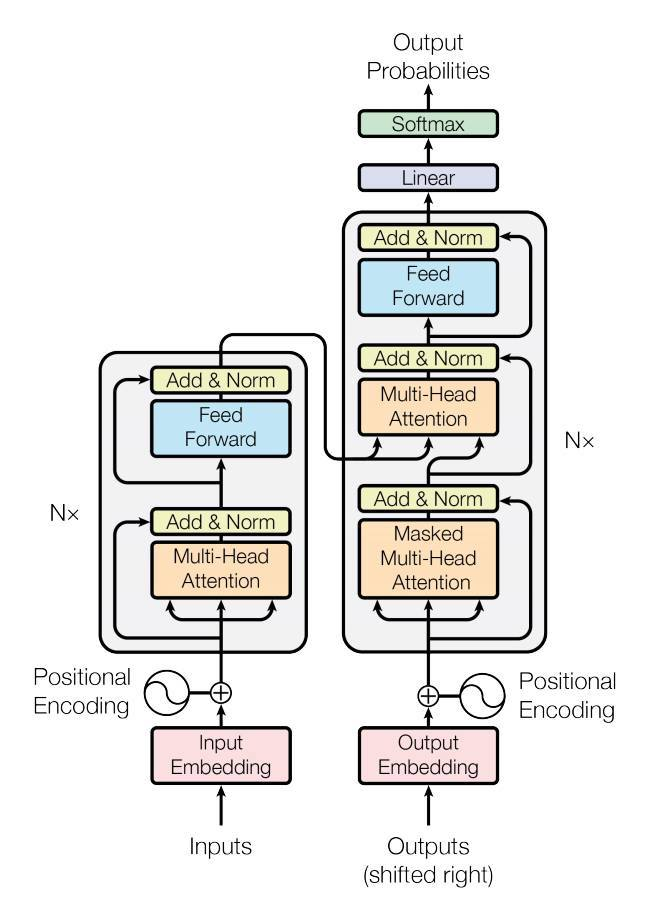

## Hugging Face 
Для работы с GPT нам нужно будет скачать предобученную модель. Лучший выбор для работы с трансформерами — это библиотеки от **Hugging Face**: `transformers`, `tokenizers`, `datasets` — самые любимые библиотеки любого нлпшника. Все они разработаны стартапом Hugging Face, который стремится стандартизировать архитектурные решения для работы с transformer-based моделями. Также они выполняют функцию своеобразного хаба предобученных весов огромного количества трансформеров.
В данном туториале мы будем работать только с библиотекой transformers и, для наглядности, с русскоязычной моделью ruGPT3 от Сбера.

In [ ]:
!pip install transformers # Сначала установим библиотеку transformers

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
DEVICE = torch.device("cuda:0")

# Для большей наглядности будем работать с русскоязычной версией GPT от Сбера.
# Ниже находятся команды для загрузки и инициализации модели и токенизатора.
model_name_or_path = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path).to(DEVICE)


## Языковое моделирование
Чтобы понять как работает GPT нужно понять, какую задачу учится решать эта модель. Языковое моделирование — это предсказание следующего слова (или куска слова) с учётом предыдущего контекста. На картинке пример того, как с задачей языкового моделирования справляется поиск Яндекса.



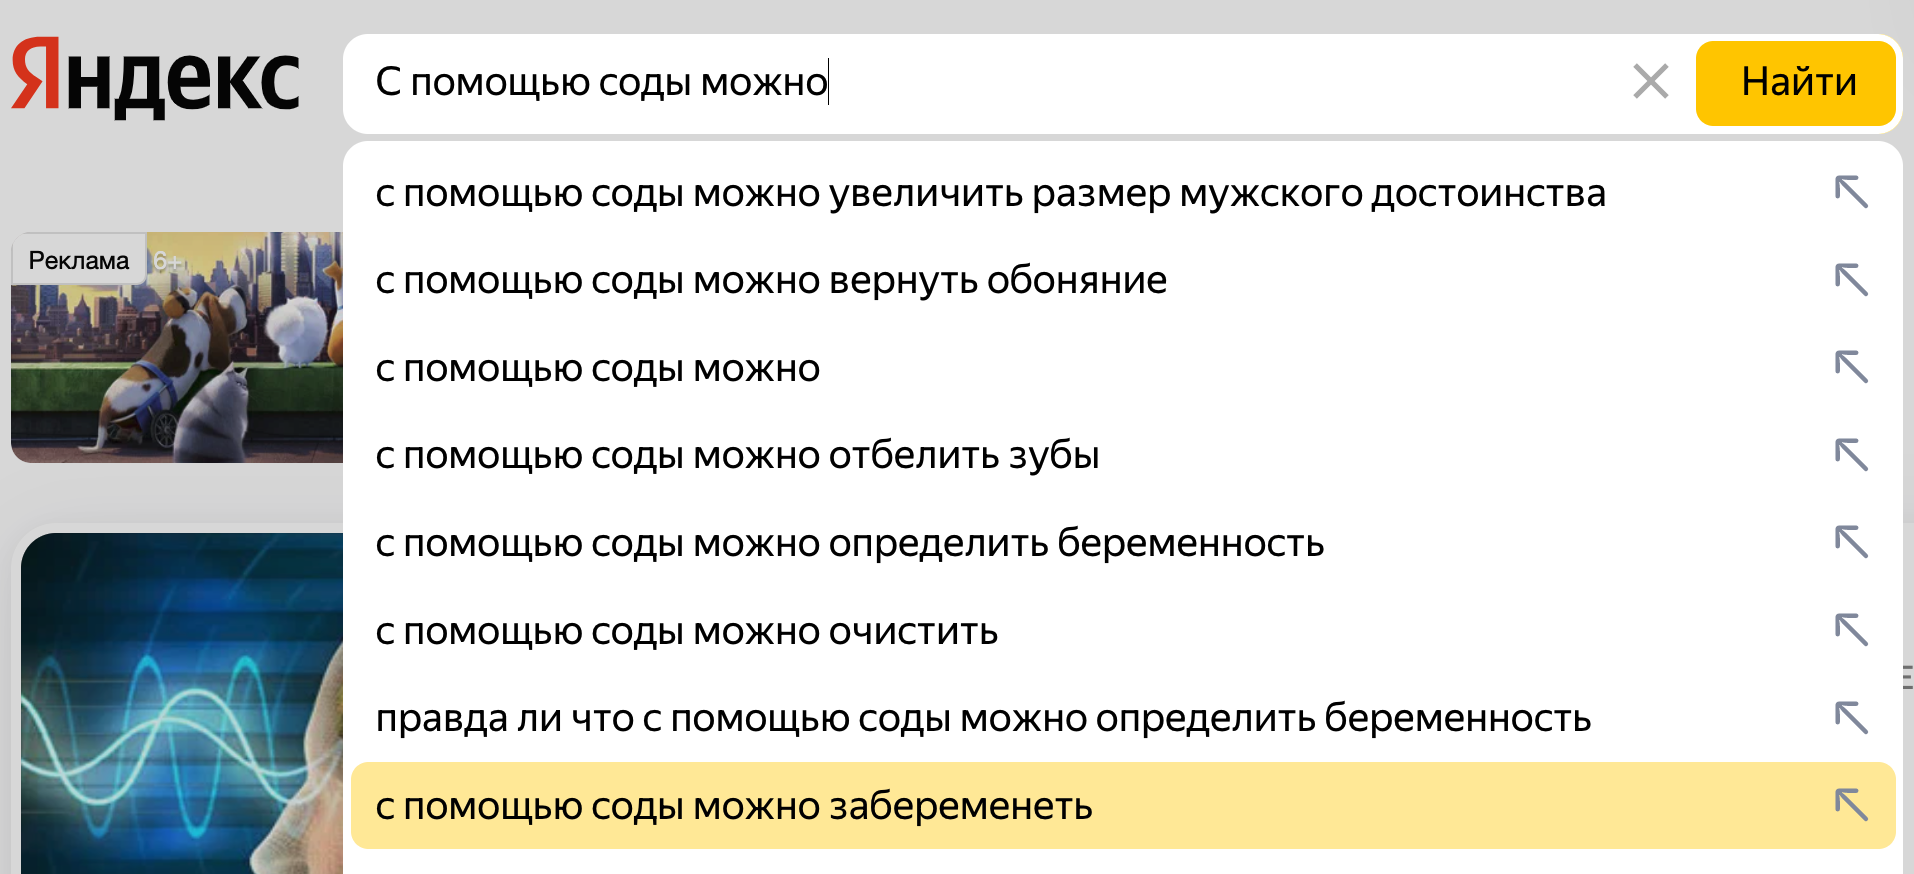

Для того чтобы "всего-лишь" дописывать текст, модель должна очень хорошо понимать его смысл и даже иметь какие-то свои знания о реальном мире. Внутренние знания модели можно попытаться использовать модифицируя «левый контекст» текста. Это позволяет решать множество задач: отвечать на вопросы, суммаризировать текст и даже создавать диалоговые системы! 

Например, если мы хотим при помощи языковой модели ответить на вопрос **«Сколько будет 2+2?»**, то мы можем подать на вход модели следующий текст:\
`«Вопрос: Сколько будет 2+2? Ответ: … »`\
и самым естественным продолжением такого текста будет ответ на вопрос, поэтому модель допишет `«4»`

Похожим способом можно кратко пересказывать тексты и целые книги, если в конце дописывать `«TL:DR»`, потому что модель во время обучения запомнила, что после этих символов идёт краткое содержание. Подбор модификаций текста называется **«Prompt Engineering»**. Такая простая идея позволяет решать практически неограниченное количество задач. Именно поэтому многие считают GPT-3 подобием сильного искусственного интеллекта.


In [ ]:
# prompt engineering 
text = "Вопрос: 'Сколько будет 2+2?'\nОтвет:" 
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
out = model.generate(input_ids, do_sample=False) 

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Вопрос: 'Сколько будет 2+2?'
Ответ: '2+2=4'


# Как работает GPT

## Токенизация
Машинное обучение лучше справляется с числами, чем с текстом, поэтому нам необходима процедура токенизации — преобразование текста в последовательность чисел.

Самый простой способ сделать это — назначить каждому уникальному слову своё число — токен, а затем заменить все слова в тексте на эти числа. Но есть проблема: слов и их форм очень много (миллионы) и поэтому словарь таких слов - чисел получится чересчур большим, а это будет затруднять обучение модели. Можно разбивать текст не на слова, а на отдельные буквы (char-level tokenization), тогда в словаре будет всего несколько десятков токенов, НО в таком случае уже сам текст после токенизации будет слишком длинным, а это тоже затрудняет обучение.

Обычно предпочтительнее выбрать что-то среднее, например, можно разбивать слова на наиболее общие части и представлять их полные версии как комбинации этих кусков (см. картинку). Такой способ токенизации называется BPE (Byte Pair Encoding). Но даже это иногда не самый оптимальный выбор. Чтобы сжать словарь ещё сильнее для обучения GPT OpenAI использовали byte-level BPE токенизацию. Эта модификация BPE работает не с текстом, а напрямую с его байтовым представлением. Использование такого трюка позволило сжать словарь до всего-лишь ~50k токенов при том, что с его помощью всё ещё можно выразить любое слово на любом языке мира (и даже эмодзи).

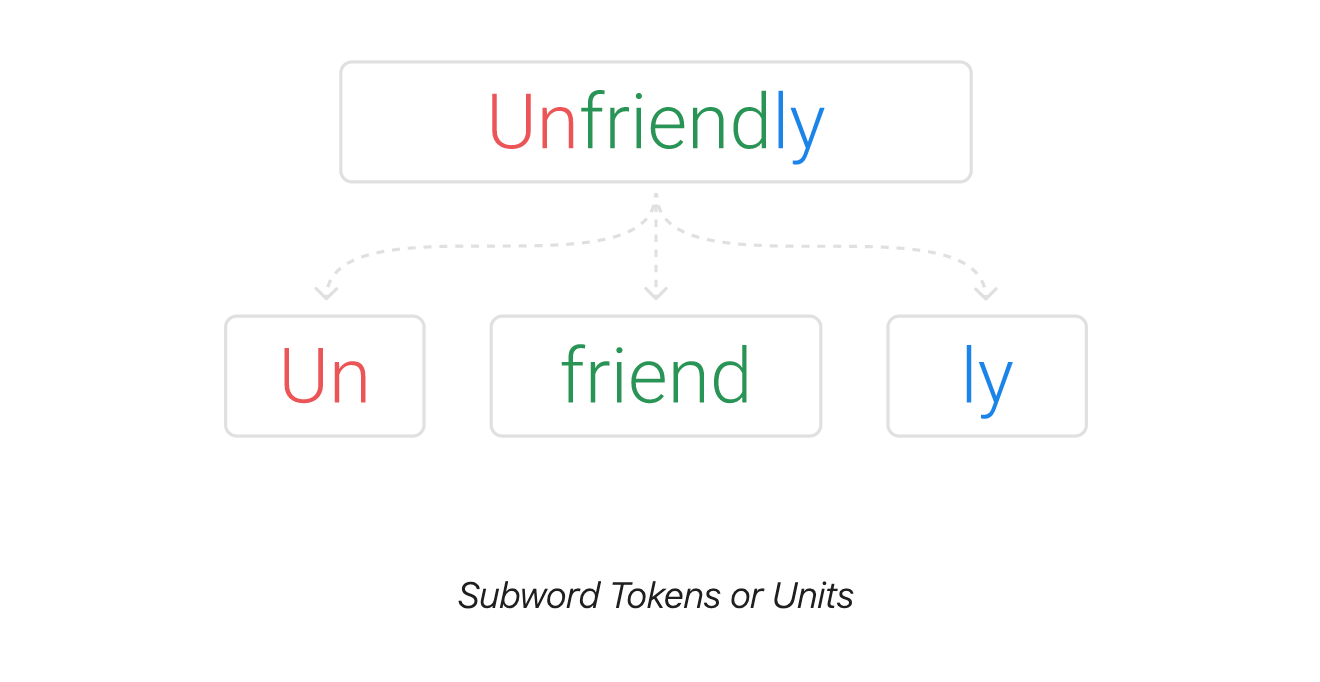

In [ ]:
# Пример токенизации
text = "Токенизируй меня" # Изначальные текст
tokens = tokenizer.encode(text, add_special_tokens=False) # Процесс токенизации с помощьюю токенайзера ruGPT-3
decoded_tokens = [tokenizer.decode([token]) for token in tokens] # Обратная поэлементая токенизация

print("text:", text)
print("tokens: ", tokens)
print("decoded tokens: ", decoded_tokens)

text: Токенизируй меня
tokens:  [789, 368, 337, 848, 28306, 703]
decoded tokens:  ['Т', 'ок', 'ени', 'зи', 'руй', ' меня']


Так как GPT использует byte-level токенизатор, то не для любого токена найдется существующий символ или слово. Некоторые токены существуют только в комбинациях. Такое случается редко, но я нашёл для вас пример таких токенов. 

In [ ]:
# эти три токена по отдельности не декодируются
print(tokenizer.decode([167]))
print(tokenizer.decode([245]))
print(tokenizer.decode([256]))

# Но вместе они образуют иероглиф
print(tokenizer.decode([167, 245, 256]))

�
�
�
撝


## Архитектура GPT

Если коротко, то при генерации продолжения текста с помощью GPT происходит следующее:

1. Входной текст токенизируется в последовательность чисел (токенов)
2. Список токенов проходит через Embedding layer (линейный слой) и превращается в список эмбеддингов (очень похоже на word2vec)
3. К каждому эмбеддингу прибавляется positional embedding, о котором я расскажу в сл. секции.
4. Далее этот список эмбеддингов начинает своё путешествие через несколько одинаковых блоков (Transformer Decoder Block), о которых я тоже расскажу потом.
5. После того как список эмбеддингов пройдёт через последний блок, эмбеддинг, соответствующий последнему токену матрично умножается на всё тот же входной но уже транспонированный Embedding Layer и после применения SoftMax получается распределение вероятностей следующего токена.
6. Из этого распределения выбираем следующий токен (например с помощью функции argmax)
7. Добавляем этот токен к входному тексту и повторяем шаги 1-6




!["gpt2"](https://cdn-images-1.medium.com/max/600/1*ZyYg2xpZyIsDNSfNKkk1uA.gif)

## Positional Encoding

Так уж получилось, что в отличие от рекурентных сетей архитектура трансформера не чувствительна к порядку входных токенов, то есть даже если перемашать слова местами, то аутпут будет получаться всё равно одинаковым (permutation invarience).

Но ведь в языке порядок слов критически важен! Чтобы его учитывать пришлось придумать костыль — positional encoding. Этот механизм позволяет трансформерам "видеть" порядок входных токенов. Грубо говоря, positional encoding — это любой способ кодирования позиции слова внутри эмбеддинга. Самый простой способ это сделать — просто конкатенировать к эмбеддингу номер позиции слова, но это работает очень плохо. Поэтому в GPT используется кодирование позиции в виде вектора, который прибавляется к эмбеддингу токена. Эти позиционные эмбеддинги можно зафиксировать заранее как в оригинальном трансформере (они на картинке), либо обучать, как в случае GPT.

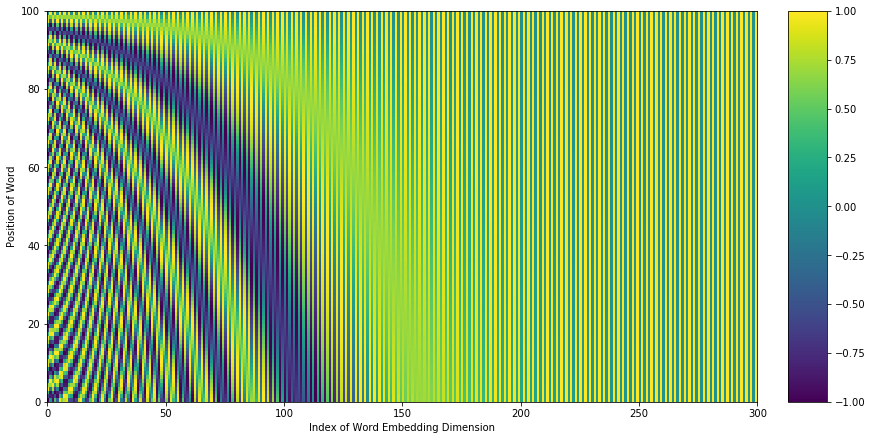

## Transformer Decoder Block

Вот так выглядит главная структурная часть GPT: self-attention, нормализация, feed-forward и residual connections.


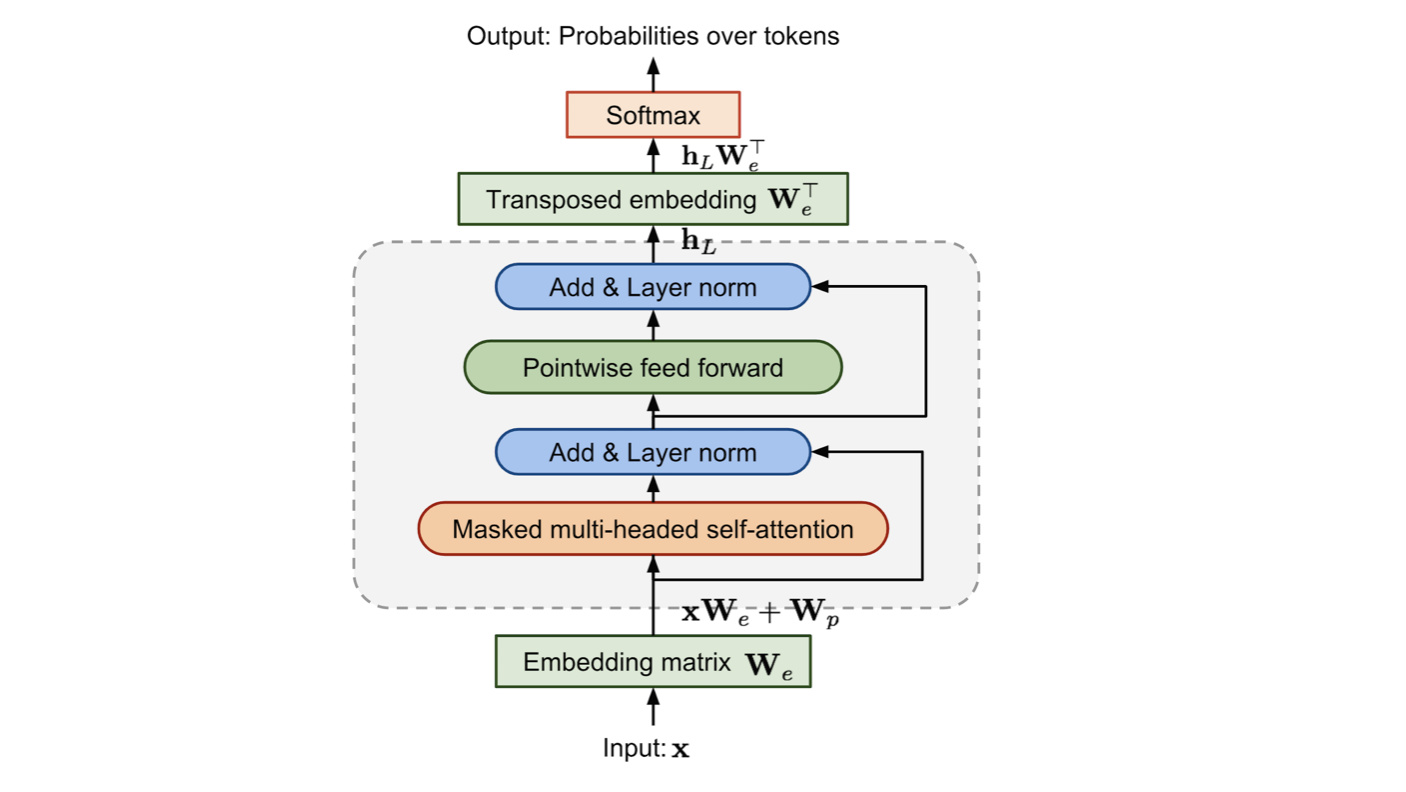

## Методы Генерации текста
Как я говорил выше, языковая модель выдаёт распределение вероятностей следующего токена, а эту информацию можно по-разному использовать для генерации текста. 

Для наглядности применим все основные методы для продолжения следующего  \
`'Определение: "Нейронная сеть" - это'`

In [ ]:
# Заранее токенизируем текст
text = 'Определение: "Нейронная сеть" - это'
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)

### Greedy Search
Самый простой способ — это аргмаксная генерация (greedy search), когда мы каждый раз выбираем токен, у которого максимальная вероятность. Это не самый лучший метод, так как в таком случае генерация застревает в локальных минимумах и часто выдаёт повторяющиеся фрагменты, например `the the the the ...`.

In [ ]:
# Пример аргмаксного сэмплирования
out = model.generate(input_ids, do_sample=False, max_length=30)

# Декодирование токенов
generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Определение: "Нейронная сеть" - это компьютерная программа, которая позволяет создавать и анализировать нейронные сети. Нейронные сети


### Beam Search
Чуть более сложный и качественный способ сэмплирования — это beam search. В этом случае на каждом шаге мы выбираем не только один самый вероятный токен, а сразу несколько (`beam-size`), и дальше продолжаем поиск для каждого из выбранных токенов. Таким образом мы разветвляем пути генерации, получая несколько вариантов сгенерированного текста. В итоге можно выбрать тот вариант, у которого лучшая перплексити (уверенность модели в реалистичности текста). Такая генерация обладает хорошей когерентностью (связностью), но обычно у них не хватает "человечности", они кажутся сухими и скучными. Также это не полностью решает проблему повторяющихся фрагментов генерации.

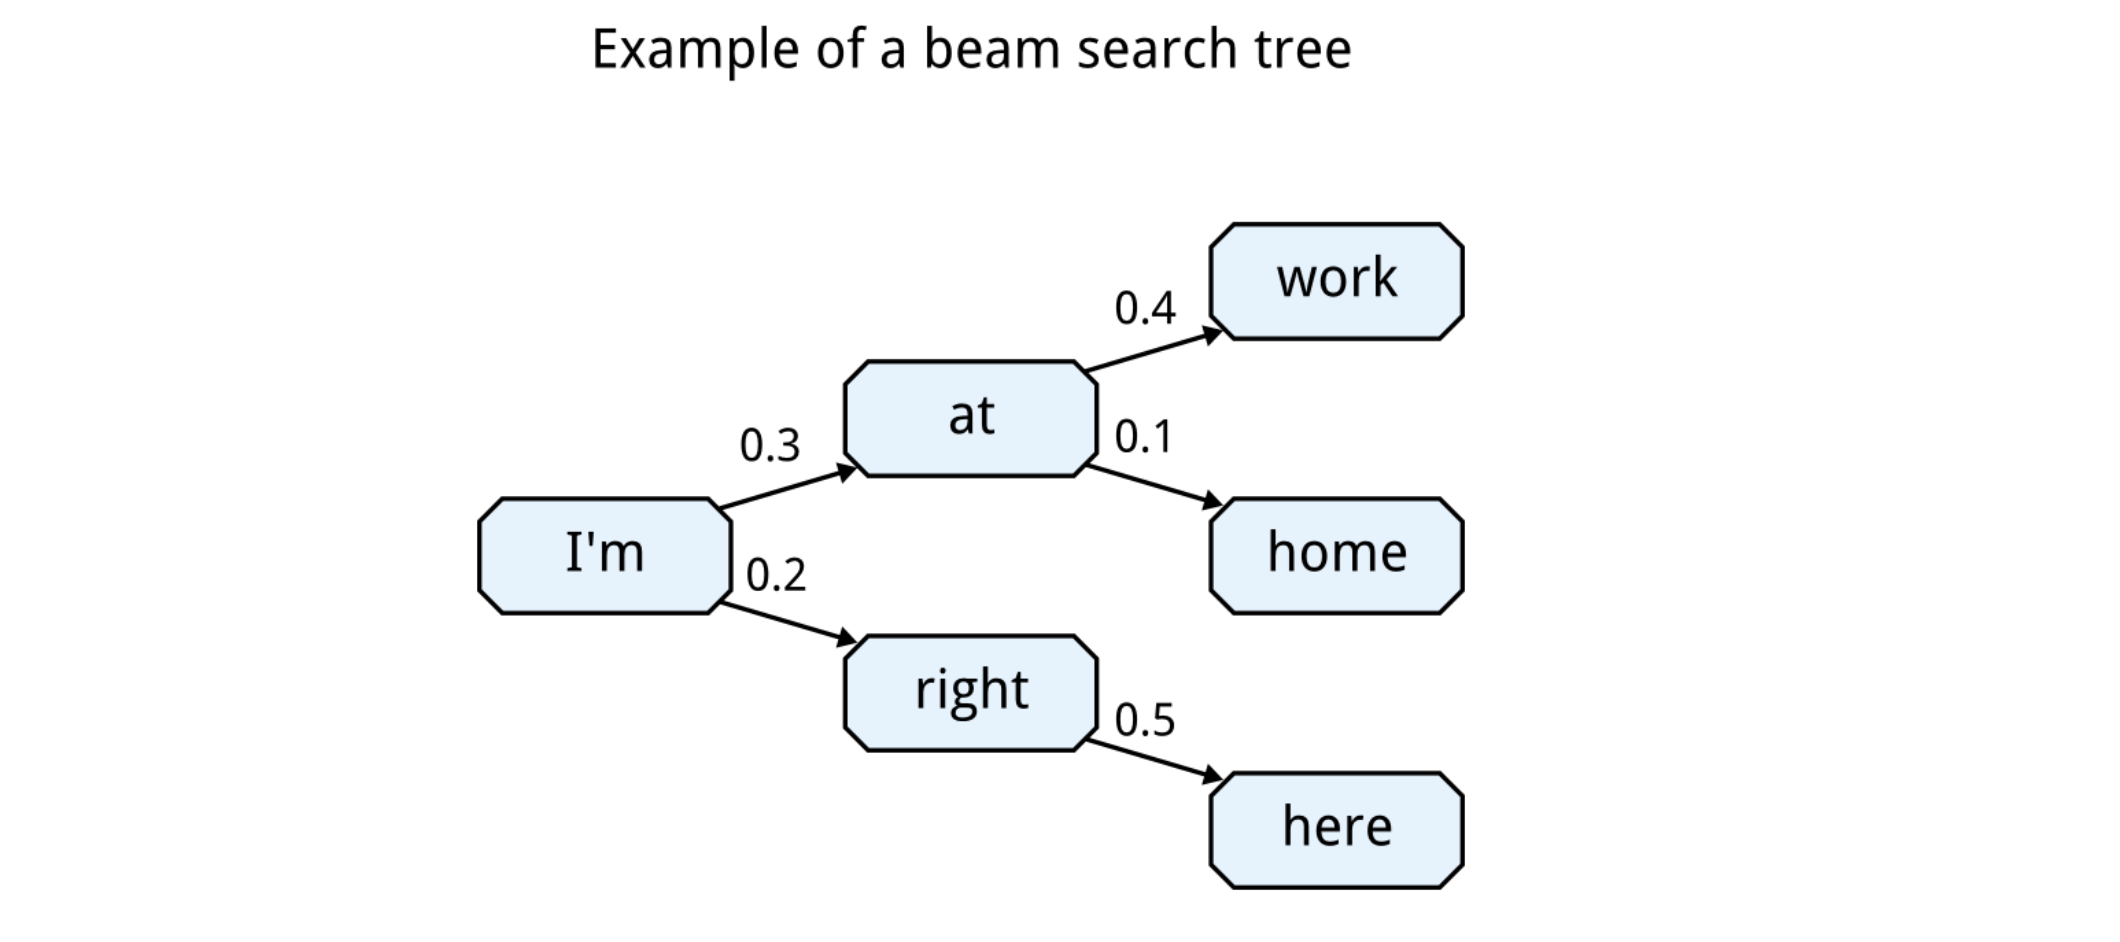

In [ ]:
# Пример генерации с помощью beam-search
out = model.generate(input_ids, do_sample=False, num_beams=5, max_length=30)

# Декодирование токенов
generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Определение: "Нейронная сеть" - это сеть, состоящая из множества нейронов, соединенных друг с другом. Нейронная


### Сэмплирование с Температурой
Чтобы добавить тексту непредсказуемости и человечности можно использовать вероятностное сэмплирование с температурой. При такой генерации мы берём не самый вероятный токен, а выбираем его "случайно" с учётом распределения вероятностей. Параметр температуры позволяет контролировать степень рандомности. При нулевой температуре этот метод совпадает с аргмаксным сэмплированием, а при очень большой температуре токены будут выбираться совсем наугад. Обычно хорошо работает температура в диапазоне `0.8 - 2.0`. Формула модификации распределения вероятностей очень похожа на формулу распределения Больцмана. Чем выше температура системы тем больше "размазывается" распределение вероятностей её возможных состояний, отсюда слово "температура".

`p'=softmax(log(p)/t)`

Но у этого метода есть и минусы, ведь случайная природа генерации будет иногда приводить к совсем уж некорректным результатам, хоть и редко.

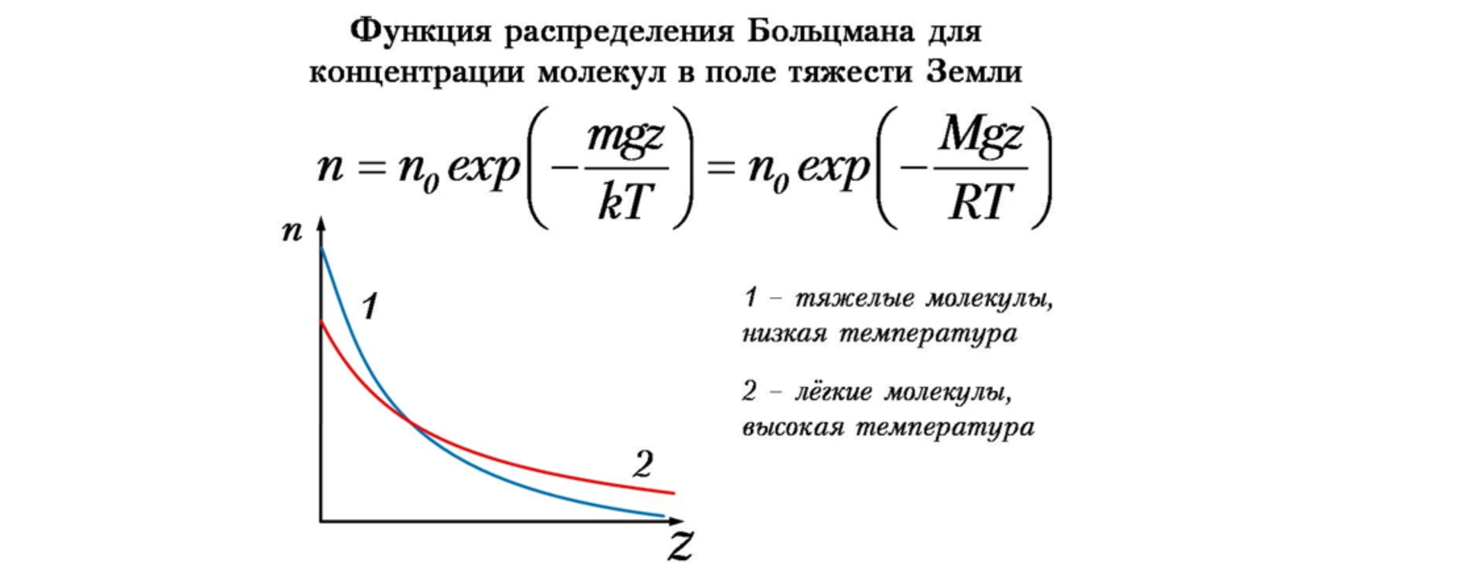

In [ ]:
# Пример вероятностного сэмплирования
out = model.generate(input_ids, do_sample=True, temperature=1.3, max_length=30)

# Декодирование токенов
generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Определение: "Нейронная сеть" - это модель, при которой каждый элемент сети имеет "исполнительный элемент" - "всплеск


### Сэмплирование с Ограничением Маловероятных Токенов (Nucleus sampling)
Для запрета сэмплирования совсем уж некорреткных токенов вводят `top-k` или `top-p` ограничения. В этом случае генерация тоже происходит случайным образом, но мы заранее отсекаем все маловероятные токены. В случает `top-k` мы просто зануляем все вероятнести кроме `k` самых вероятных. А в случае `top-p` мы оставляем такой минимальный сет токенов, чтобы сумма их вероятностей была не больше `p`. 

`top-p` ограничение называют **Nucleus Sampling**.

In [ ]:
# Пример вероятностного сэмплирвоания с ограничением
out = model.generate(input_ids, 
                     do_sample=True,
                     temperature=1.3,
                     top_k=20,
                     top_p=0.8,
                     max_length=30,
                    )
# Декодирование токенов
generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Определение: "Нейронная сеть" - это совокупность объектов и программ, объединенных единой целью и имеющих одинаковый функциональный характер.



# Сравнение поколений GPT


## GPT-1
**GPT — Generative Pretraining of Transformers.** Первая версия этой модели состояла из 12 слоёв и была обучена на 7000 книг. Как языковая модель она работала не очень хорошо (длинные тексты генерировались плохо), но при файнтюнинге на отдельных задачах выбила несколько SOTA результатов. Собственно, статья была про то, что usupervised language lodeling pretraining улучшает качество дальнейшего файнтюнинга. Максимальный размер контекста у GPT-1 — 512 токенов.

## GPT-2

SOTA результаты первой GPT держались недолго, так как появился BERT. В OpenAI психанули и решили значительно прокачать свою модель. Во первых, они её сделали в **10 раз больше**: 48 слоёв ~ **1.5B параметров**. А во вторых обучили на невероятно большом объёме данных — к книгам добавили **8 миллионов сайтов** (с хорошим рейтингом на реддите). Суммарно получилось 40 гб текста. Архитектурно модель изменилась не сильно — только немного переместили слои нормализации.

В итоге, оказалось, что GPT-2 настолько стала лучше, что научилась писать длинные связные тексты и даже решать при помощи prompt engineering множество новых задач!

Максимальный размер контекста у GPT-2 — 1024 токенов

## GPT-3
Опять же модель сделали в 10 раз больше (175B параметров) и обучили на ещё большем количестве данных (570GB текста). Из архитектурных изменений — только немного оптимизировали attention. После такого апгрейда модель стала настолько крутой, что научилась писать рабочий программный код (так появился [CODEX](https://openai.com/blog/openai-codex/)) и решать много других почти сверхестественных задач ([воскрешать мёртвых ](https://futurism.com/openai-dead-fiancee)).

Максимальный размер контекста у GPT-3 — 2048 токенов.

# Файнтюнинг

Для файнтюнинга скачаем модель поменьше, чтобы она точно поместилась на GPU.

In [ ]:
model_name_or_path = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path).to(DEVICE)

Downloading:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/526M [00:00<?, ?B/s]

## Как происходит обучение
Обучающий текст нарезается на случайные куски, которые составляются в последовательности из 1024 (2048 у GPT-3) токенов разделяясь специальным `<|endoftext|>` символом. Во время обучения, модель учится предсказывать (классифицировать) каждый токен в последовательности один за другим при помощь `CrossEntropy Loss.`

Так как входная последовательность всегда заполнена до конца, padding не используется. Но во время инференса, длина входного текста может быть произвольной, поэтому надо явно указывать чем паддить оставшиеся позиции. По дефолту использутеся тот же `<|endoftext|>`. 

В кастомных версиях GPT вышесказанное может модифицироваться. Напримре в ruGPT3 гораздо больше специальных токенов: `<s\>`, `<s>`, `<pad>`, `<unk>`

## Обучающие данные
Будем учить GPT генерировать стихи Пушкина. В качестве обучающих данных возьмём всего-лишь один стих.

In [ ]:
text = """Мороз и солнце; день чудесный!
Еще ты дремлешь, друг прелестный —
Пора, красавица, проснись:
Открой сомкнуты негой взоры
Навстречу северной Авроры,
Звездою севера явись!
Вечор, ты помнишь, вьюга злилась,
На мутном небе мгла носилась;
Луна, как бледное пятно,
Сквозь тучи мрачные желтела,
И ты печальная сидела —
А нынче... погляди в окно:
Под голубыми небесами
Великолепными коврами,
Блестя на солнце, снег лежит;
Прозрачный лес один чернеет,
И ель сквозь иней зеленеет,
И речка подо льдом блестит.
Вся комната янтарным блеском
Озарена. Веселым треском
Трещит затопленная печь.
Приятно думать у лежанки.
Но знаешь: не велеть ли в санки
Кобылку бурую запречь?
Скользя по утреннему снегу,
Друг милый, предадимся бегу
Нетерпеливого коня
И навестим поля пустые,
Леса, недавно столь густые,
И берег, милый для меня."""

В библиотеке transformers есть готовые инструменты для подготовки датасета и даталодера. На вход нужен всего лишь один `.txt` файл с обучающим текстом.

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Сохраним обучающие данные в .txt файл 
train_path = 'train_dataset.txt'
with open(train_path, "w") as f:
    f.write(text)

# Создание датасета
train_dataset = TextDataset(tokenizer=tokenizer,file_path=train_path,block_size=64)
  
# Создание даталодера (нарезает текст на оптимальные по длине куски)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


## Training
Для файнтюнинга нам понадобится объект класса Trainer, который сделает всё грязную работу за нас (посылаем лучи добра Hugging Face). Далее нужно будет всего-навсего запустить `trainer.train()`

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./finetuned", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=200, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    warmup_steps=10,# number of warmup steps for learning rate scheduler
    gradient_accumulation_steps=16, # to make "virtual" batch size larger
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (torch.optim.AdamW(model.parameters(),lr=1e-5),None) # Optimizer and lr scheduler
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 4
  Num Epochs = 200
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 512
  Gradient Accumulation steps = 16
  Total optimization steps = 200


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=200, training_loss=0.03011104345321655, metrics={'train_runtime': 48.7211, 'train_samples_per_second': 16.42, 'train_steps_per_second': 4.105, 'total_flos': 26129203200000.0, 'train_loss': 0.03011104345321655, 'epoch': 200.0})

# Результат файнтюнинга
Готово! Теперь давайте посмотрим что же сочинит GPT в стиле Пушкина если на вход подать такую строчку:

"Как же сложно учить матанализ!"

In [ ]:
# Пример вероятностного сэмплирвоания с ограничением
text = "Как же сложно учить матанализ!\n"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids, 
                        do_sample=True,
                        num_beams=2,
                        temperature=1.5,
                        top_p=0.9,
                        max_length=100,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:2259: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size



Как же сложно учить матанализ!
Чтобы в математике успеха добиться,
Попробуйте по буквам составить
Решение задачи по алгебре.
Умножь два на два и реши задачу по геометрии.
Умножь на три и реши задачу по алгебре.

Что делать если нетбук
в сервис
Купить новый
купить новый. и не заморачиваться с зарядкой
купить новый новый
Купить новый
Купить новый


# Полезные ссылки
1. [GPT в картинках](https://habr.com/ru/post/490842/) — очень подробный разбор внутренней архитектуры GPT-2 с акцентом на иллюстрации.
2. [Трансформер в картинках](https://habr.com/ru/post/486358/) — очень подробный разбор архитектуры Transformer с акцентом на иллюстрации.
3. [Tokenizers tutorial](https://huggingface.co/docs/transformers/tokenizer_summary) — краткий разбор всех типов токенизаторов от Huggingface с примерами.
4. [Как генерировать текст](https://huggingface.co/blog/how-to-generate) — обзор способов сэмплирования текста с помощью языковых моделей (бимсёрч и тд).
5. [Attention is All You Need](https://arxiv.org/pdf/1706.03762.pdf) — оригинальная статья про первый трансформер.
6. [GPT-1](https://openai.com/blog/language-unsupervised/) — статья в блоге OpenAI про GPT-1.
7. [GPT-2](https://openai.com/blog/better-language-models/) — статья в блоге OpenAI про GPT-2.
8. [GPT-3](https://openai.com/blog/gpt-3-apps/) — статья в блоге OpenAI про GPT-3.
9. [WebGPT](https://openai.com/blog/improving-factual-accuracy/) — статья в блоге OpenAI про GPT-3, обученную гуглить.
10. [Codex](https://openai.com/blog/openai-codex/) — статья в блоге OpenAI про GPT-3, обученную писать код.